Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/ran/cs566/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ran/cs566/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ran/cs566/.venv/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
No checkpoint found, starting from scratch.


Epoch [1/10]  Loss: 0.0070
LPIPS: 0.0483


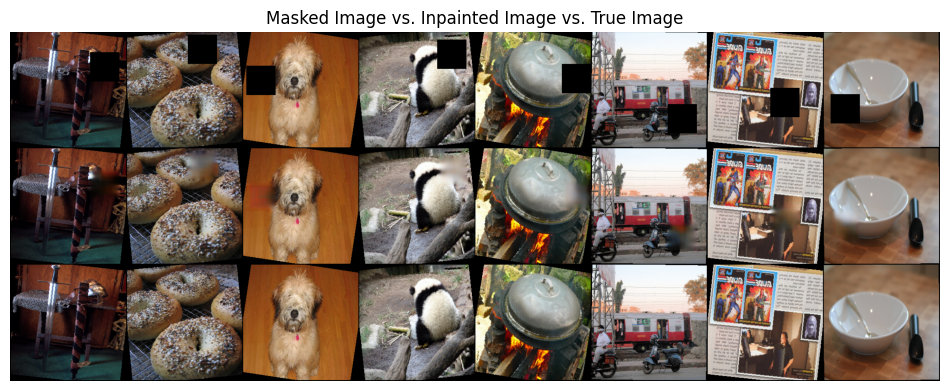

Saved checkpoint to checkpoints_100k_unet_rect/latest.pt


Epoch [2/10]  Loss: 0.0062
LPIPS: 0.0483


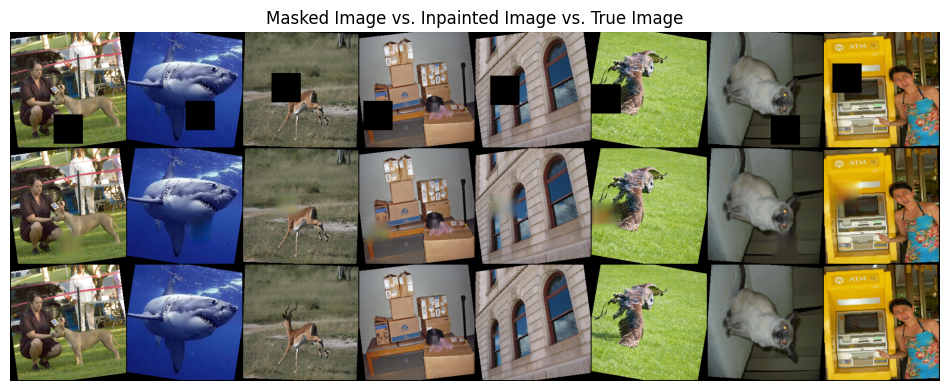

Saved checkpoint to checkpoints_100k_unet_rect/latest.pt


Epoch [3/10]  Loss: 0.0059
LPIPS: 0.0436


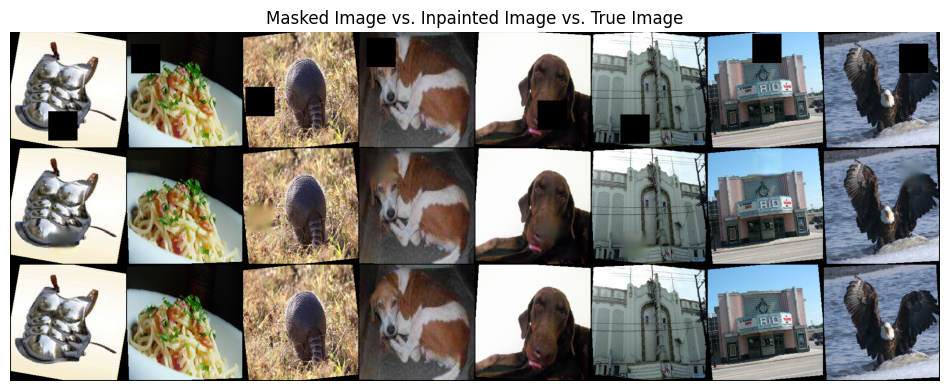

Saved checkpoint to checkpoints_100k_unet_rect/latest.pt


Epoch [4/10]  Loss: 0.0057
LPIPS: 0.0508


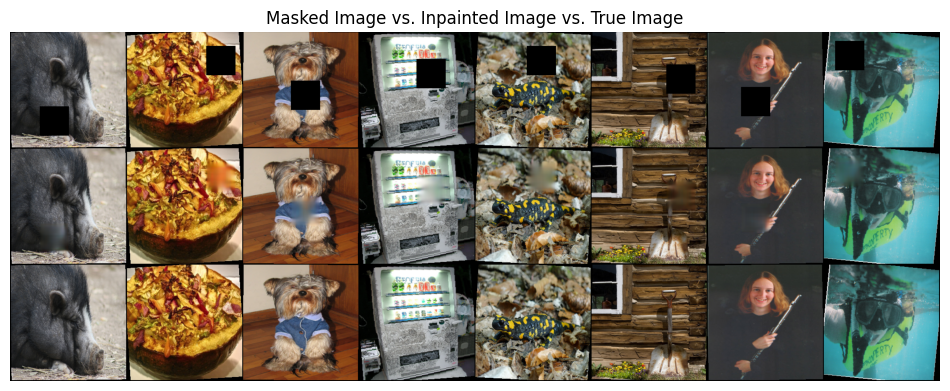

Saved checkpoint to checkpoints_100k_unet_rect/latest.pt


Epoch [5/10]  Loss: 0.0056
LPIPS: 0.0469


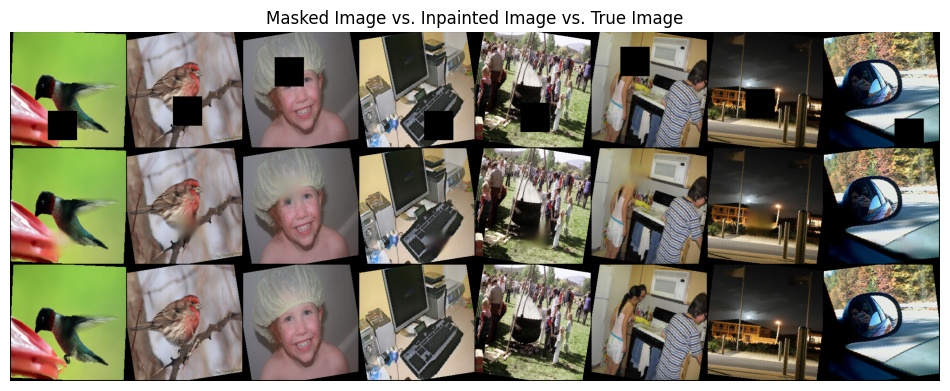

Saved checkpoint to checkpoints_100k_unet_rect/latest.pt


Epoch [6/10]  Loss: 0.0056
LPIPS: 0.0497


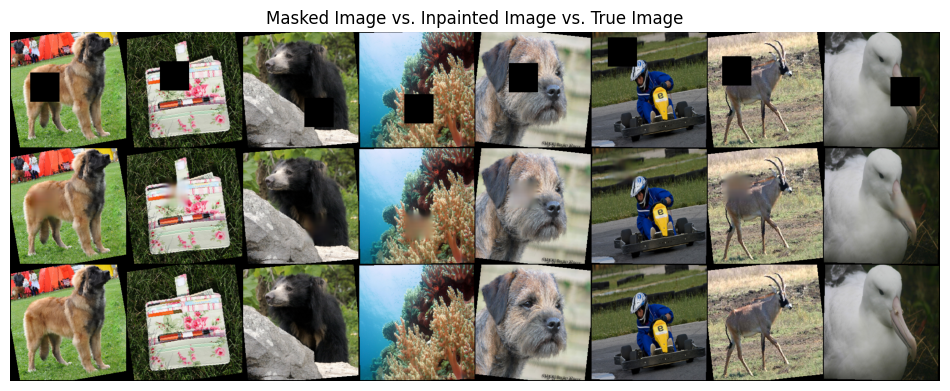

Saved checkpoint to checkpoints_100k_unet_rect/latest.pt


Epoch [7/10]  Loss: 0.0055
LPIPS: 0.0423


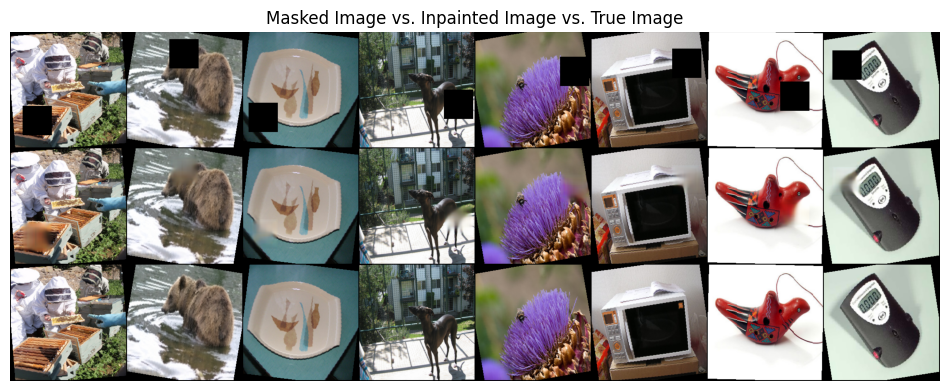

Saved checkpoint to checkpoints_100k_unet_rect/latest.pt


Epoch [8/10]  Loss: 0.0055
LPIPS: 0.0544


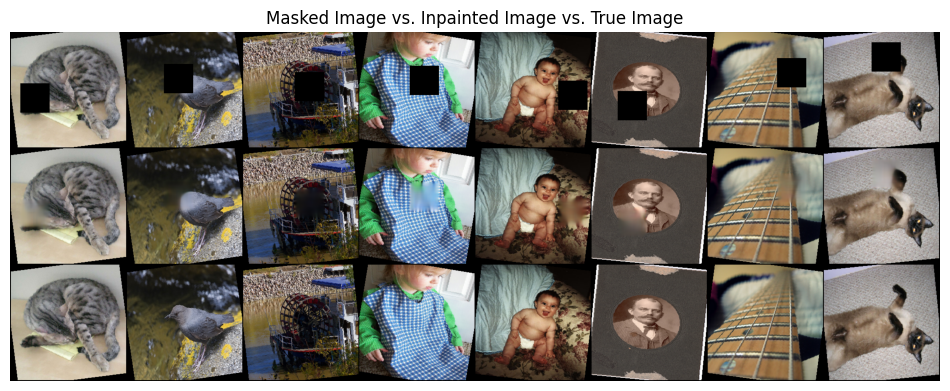

Saved checkpoint to checkpoints_100k_unet_rect/latest.pt


Epoch [9/10]  Loss: 0.0054
LPIPS: 0.0456


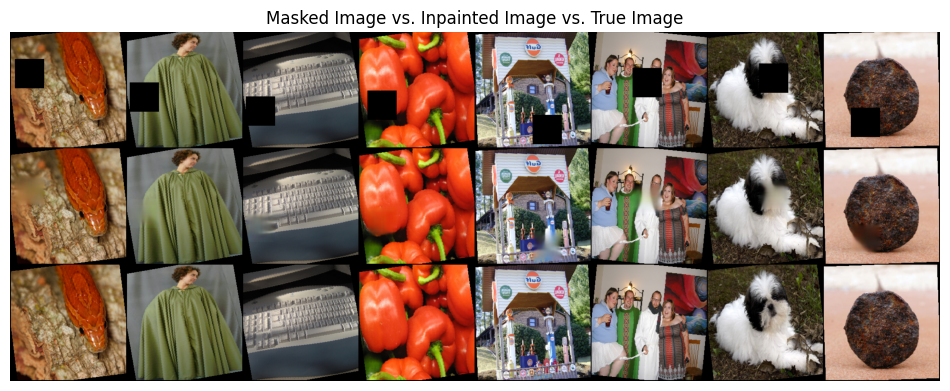

Saved checkpoint to checkpoints_100k_unet_rect/latest.pt


Epoch [10/10]  Loss: 0.0054
LPIPS: 0.0333


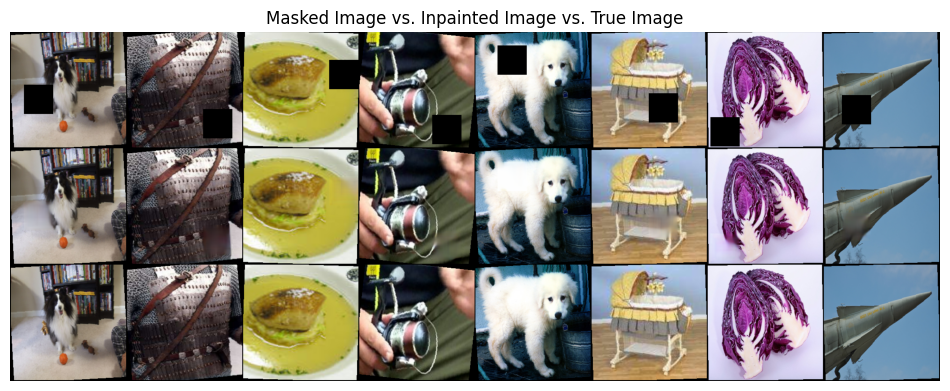

Saved checkpoint to checkpoints_100k_unet_rect/latest.pt
Saved final UNet (rectangular mask) weights to checkpoints_100k_unet_rect/unet_rectangular_inference.pth


In [ ]:
# Baseline U-Net (Rectangular Mask)

DATASET_PATH = "/home/ran/cs566/large100k_sp"

import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt
import lpips



# Rectangular mask generation
def random_mask(image, mask_ratio=0.25):
    w, h = image.size
    mask_w, mask_h = max(1, int(w * mask_ratio)), max(1, int(h * mask_ratio))
    x = random.randint(0, w - mask_w)
    y = random.randint(0, h - mask_h)

    mask = Image.new("L", (w, h), 255)
    draw = ImageDraw.Draw(mask)
    draw.rectangle([x, y, x + mask_w, y + mask_h], fill=0)
    return mask


# Dataset
class ILSVRCInpaintDataset(Dataset):
    def __init__(self, root_dir):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.resize = transforms.Resize((256, 256))
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
        ])
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        img = self.resize(img)
        img = self.transform(img)

        # Rectangular hole
        mask = random_mask(img)

        img_tensor = self.to_tensor(img)
        mask_tensor = (self.to_tensor(mask) > 0.5).float()  
        masked_t = img_tensor * mask_tensor

        sample = {"img": img_tensor, "masked": masked_t, "mask": mask_tensor}
        return sample


# Baseline U-Net
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Encoder
        for feature in features:
            self.downs.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, feature, 3, padding=1, bias=False),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, 3, padding=1, bias=False),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                )
            )
            in_channels = feature

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features[-1], features[-1] * 2, 3, padding=1),
            nn.BatchNorm2d(features[-1] * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(features[-1] * 2, features[-1] * 2, 3, padding=1),
            nn.BatchNorm2d(features[-1] * 2),
            nn.ReLU(inplace=True),
        )

        # Decoder
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(feature * 2, feature, 3, padding=1, bias=False),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, 3, padding=1, bias=False),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                )
            )

        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        for down in self.downs:
            x = down(x)
            skips.append(x)
            x = F.max_pool2d(x, 2)

        x = self.bottleneck(x)
        skips = skips[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skips[idx // 2]
            x = self.ups[idx + 1](torch.cat((skip, x), dim=1))

        x = torch.sigmoid(self.final_layer(x))
        return x


# Training epoch
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training", leave=False):
        masked = batch["masked"].to(device, non_blocking=True)
        img = batch["img"].to(device, non_blocking=True)
        mask = batch["mask"].to(device, non_blocking=True)

        optimizer.zero_grad()
        pred = model(masked)
        # L1 loss only over the hole region (1 - mask)
        loss = criterion(pred * (1 - mask), img * (1 - mask))
        loss.backward()
        optimizer.step()

        total_loss += float(loss.detach().cpu())
    return total_loss / len(dataloader)


# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ILSVRCInpaintDataset(DATASET_PATH)
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()
lpips_model = lpips.LPIPS(net="vgg").to(device).eval()

epochs = 10

# Checkpoint setup 
checkpoint_dir = "checkpoints_100k_unet_rect"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "latest.pt")

start_epoch = 0

# Resume if checkpoint exists
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path} ...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch + 1}")
else:
    print("No checkpoint found, starting from scratch.")


for epoch in range(start_epoch, epochs):
    avg_loss = None 
    try:
        avg_loss = train_epoch(model, dataloader, optimizer, criterion, device)
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.4f}")

        with torch.no_grad():
            batch = next(iter(dataloader))
            masked = batch["masked"].to(device)
            img = batch["img"].to(device)
            mask = batch["mask"].to(device)

            pred = model(masked)

            combined_inpainted_img = pred * (1 - mask) + img * mask
            combined_lp = combined_inpainted_img * 2 - 1
            img_lp = img * 2 - 1
            lpips_val = lpips_model(combined_lp, img_lp).mean().item()
            print(f"LPIPS: {lpips_val:.4f}")

            show = torch.cat([masked, combined_inpainted_img, img], dim=0)
            grid = make_grid(show.cpu(), nrow=masked.size(0), padding=2)
            plt.figure(figsize=(1.5 * masked.size(0), 6))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis("off")
            plt.title("Masked Image vs. Inpainted Image vs. True Image")
            plt.show()

        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            checkpoint_path,
        )
        print(f"Saved checkpoint to {checkpoint_path}")

    except KeyboardInterrupt:
        print("\nTraining interrupted by user, saving checkpoint...")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            checkpoint_path,
        )
        print(f"Checkpoint saved to {checkpoint_path}. Re-run later to resume.")
        raise

    except Exception as e:
        print(f"\nError during epoch {epoch+1}: {e}")
        print("Saving checkpoint before exiting...")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            checkpoint_path,
        )
        print(f"Checkpoint saved to {checkpoint_path}. Fix the issue and re-run to resume.")
        raise

# Save final weights for inference
final_model_path = os.path.join(checkpoint_dir, "unet_rectangular_inference.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Saved final UNet (rectangular mask) weights to {final_model_path}")
